# Introduction

In this notebook, we'll be going over the various steps of the training process, including the pre-training workflow (MI pruning and mask correction), as well as a lightweight implementation of the model using a modified dataloader. 

If running the notebook to verify the results of the paper, please skip over the sections with the "Skip" in the header titles. These sections are here to provide complete documentation for the whole process, and much of that work has been done already to save computation time.

There are essentially several ways you can choose to use the notebook, depending on your purposes.

1. You can run the notebook start to finish, which will do most of the processing pipeline steps, in addition to local data loading and training. Sections 0-4
2. You can skip the mutual information pruning and do masking + training. Sections 1-4
3. You can directly load the trained model for test set evaluation. Sections 3-4 (skip the training cell)

In [1]:
import os
import re
import imageio as iio
from pathlib import Path
import numpy as np
from glob import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle

#AIRXD model import

from airxd_cnn.vanilla_model import ARIXD_CNN as cmodel
from torchvision.transforms import v2
import torch
from airxd_cnn.transforms import powder_normalize

In [2]:
def plot_im_and_mask(image_path, mask_path, normalized = True):
    #Load image and mask
    image = iio.v2.volread(image_path)
    if not normalized:
        image = powder_normalize(image)
    mask = iio.v2.volread(mask_path)

    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(image, cmap='binary', origin='lower',)
    ax[0].set_title('Raw data')
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='binary', origin='lower',)
    ax[1].set_title('Mask')
    ax[1].axis('off')

# Data inspection and overview

We'll be briefly plotting a few images and labelled targets from the datasets we'll be using during training.

In [40]:
from PIL import Image
import re

# #In the line below, filter out for any names with 'normalized'

# classes = [f for f in glob('data/*') if not re.search(r'normalized', f)]
# mask_paths = [f for f in glob('data/*/masks/*.tif')]
# image_paths= [f for f in glob('data/*/*.tif') if not re.search(r'mask', f) and not re.search(r'normalized', f)]

train_classes = ['Nickel', 'battery1', 'battery2', 'battery3', 'battery4', 'Perfect']

#Define class_paths as any directories in classes

#Exclude the fifth battery dataset
image_paths = [f for f in glob('data/*/*.tif') if f.split('/')[1] in train_classes]
mask_paths = [f for f in glob('data/*/masks/*.tif') if f.split('/')[1] in train_classes]

mask_paths.sort(),image_paths.sort()


(None, None)

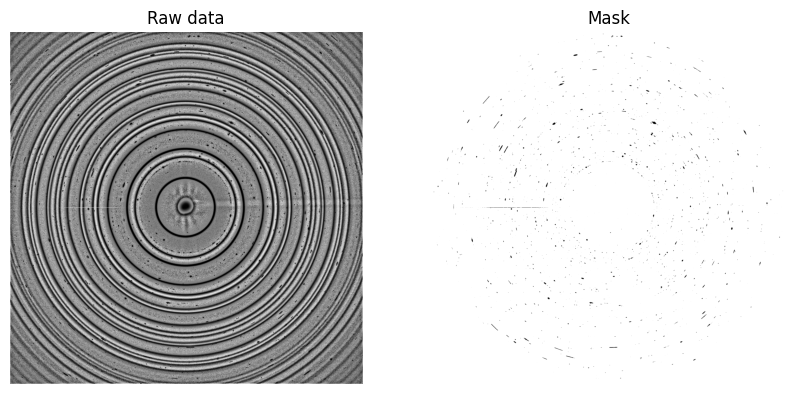

In [46]:
#Feel free to change this number to see examples from different images
example_idx = 0

plot_im_and_mask(image_paths[0], mask_paths[0], normalized = False)



# 0. Mutual Information Pruning (skip)

Below is the script used to generate the list of "pruned" images for training. This has already been run to generate a list called "pruned_list.pkl". The code below is documentation of the algorithm used in order to re-create our results exactly.

In [3]:
from sklearn.metrics import mutual_info_score
from airxd_cnn.transforms import powder_normalize
import pickle

In [4]:
def MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    return mutual_info_score(None,None, contingency=c_xy)

def calculate_MI(images):
    n = len(images)
    mi_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            mi = MI(images[i].flatten(), images[j].flatten(), 256)
            mi_matrix[i,j] = mi
            mi_matrix[j,i] = mi #Symmetry

    return mi_matrix

def cosine_similarity(u, v):
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    if norm_u == 0 or norm_v == 0:
        return 0
    
    return np.dot(u,v)/(norm_u * norm_v)

def prune_images(mi_matrix, threshold, number):
    
    selected_images = []

    #Select the n most "unique" images
    remaining_indices = set(range(mi_matrix.shape[0]))
    for i in range(number):
        mmi_values = { #Mean mutual information
            i: np.mean([mi_matrix[i,j] for j in remaining_indices if i != j])
            for i in remaining_indices
        }

        #Select image with lowest mean mutual information
        selected_im = min(mmi_values, key = mmi_values.get)
        selected_images.append(selected_im)

        #Remove similar images
        remaining_list = np.array(list(remaining_indices))
        selected_vector = mi_matrix[selected_im, remaining_list]
        similar_images = set()

        for j in remaining_list:
            if j == selected_im:
                continue

            mask = (remaining_list != selected_im) & (remaining_list != j)

            #Compute dot product
            similarity = cosine_similarity(selected_vector[mask], mi_matrix[j, remaining_list][mask])

            if similarity >= threshold:
                similar_images.add(j)
        
        #Remove similar images from list
        remaining_indices -= {selected_im} | similar_images

        if len(remaining_indices) <= 1:
            break

    return selected_images

In [5]:
# Materials directory list
#battery5 is excluded as it is the test set used to check out-of-distribution performance
base_dir = 'data'
materials_directories = ['battery1', 'battery2', 'battery3', 'battery4', 'Nickel']

# Get representative images for data pruning
pruned_im_list = []

for materials in materials_directories:
    image_dir = base_dir + '/' + materials

    im_list = glob(image_dir + '/*.tif')
    im_list.sort()

    ims = []

    for im in im_list:
        raw_im = iio.v2.volread(im)
        norm_im = powder_normalize(raw_im)
        ims.append(norm_im)

    mi_matrix = calculate_MI(ims)

    indices = prune_images(mi_matrix, 0.9999, 4)

    for idx in indices:
        pruned_im_list.append(im_list[idx])

with open('data/pruned_list.pkl', 'wb') as file:
    pickle.dump(pruned_im_list, file)

print(f'Pruned image list is: {pruned_im_list}')


Pruned image list is: ['data/battery1/TC-2-00000-00001.tif', 'data/battery1/TC-2-00000-00009.tif', 'data/battery1/TC-2-00000-00005.tif', 'data/battery1/TC-2-00000-00010.tif', 'data/battery2/Kinnto2-00000-00001.tif', 'data/battery2/Kinnto2-00000-00006.tif', 'data/battery2/Kinnto2-00000-00011.tif', 'data/battery3/Kinnto3-00000-00001.tif', 'data/battery4/BYS-900-00000-00015.tif', 'data/battery4/BYS-900-00000-00012.tif', 'data/battery4/BYS-900-00000-00009.tif', 'data/battery4/BYS-900-00000-00007.tif', 'data/Nickel/Ni83_ch3_RTto950_d700-00000.tif', 'data/Nickel/Ni83_ch3_RTto950_d700-00002.tif', 'data/Nickel/Ni83_ch3_RTto950_d700-00004.tif', 'data/Nickel/Ni83_ch3_RTto950_d700-00006.tif']


# 1. Mask correction (Run)

Here we first modify the masks to remove "islands" of less than 5 pixels in diameter. This is the last step after autolabelling + manual curation.

In [6]:
from scipy.ndimage import label
from skimage.measure import regionprops

In [7]:
def filter_connected_components_by_size(mask, min_size, max_size=None):
    """
    Filters connected components in the mask based on size.
    
    Parameters:
        mask (ndarray): Binary mask where spots are marked as 1, and the background is 0.
        min_size (int): Minimum number of pixels for a connected component to be kept.
        max_size (int, optional): Maximum number of pixels for a connected component to be kept. If None, no upper limit.
        
    Returns:
        filtered_mask (ndarray): Mask with only the connected components that meet the size criteria.
    """
    # Label each connected component in the binary mask
    labeled_mask, _ = label(mask)
    
    # Initialize an empty mask to hold the filtered components
    filtered_mask = np.zeros_like(mask)
    
    # Get properties of labeled regions
    regions = regionprops(labeled_mask)
    
    for region in regions:
        # Check the size of each region
        region_size = region.area
        if region_size >= min_size and (max_size is None or region_size <= max_size):
            # Add this region to the filtered mask
            filtered_mask[labeled_mask == region.label] = 1
    
    return filtered_mask


In [8]:
#Apply artifact masking procedure
#We'll be applying this to all datasets including the test dataset battery5

base_dir = 'data'
materials_directories = ['battery1', 'battery2', 'battery3', 'battery4', 'battery5', 'Nickel']

for materials in materials_directories:
    image_dir = base_dir + '/' + materials

    #Get sub image list
    mask_list = glob(image_dir + '/masks/*.tif')
    thresholded_mask_dir = image_dir + '/thresholded_mask'
    
    #Create directory for masked directories
    if not os.path.exists(thresholded_mask_dir):
        os.mkdir(thresholded_mask_dir)
    
        print(f'Masking images for material {materials}')
        #For each material take each mask in the mask list and run the island filter on it
        
        for mask_path in mask_list:
            mask = iio.v2.volread(mask_path)
            thresholded_mask = filter_connected_components_by_size(mask, 5)

            thresholded_mask_path = os.path.join(thresholded_mask_dir, os.path.split(mask_path)[-1])

            #Write new image
            iio.imwrite(thresholded_mask_path, thresholded_mask)



Masking images for material battery1
Masking images for material battery2
Masking images for material battery3
Masking images for material battery4
Masking images for material battery5


# 2. Running locally with memory constraints (Run)

In this section, we introduce a lightweight model that performs a similar training procedure with the same CNN architecture, albeit with a modified dataloader that is much less RAM intensive
can be run on most reasonable local computers.

The main difference is that when the 2880 x 2880 images are broken up into tiles, these tiles are randomly rotated/flipped, rather than all transformations being included in the training set (which was how the 16x model was trained from the manuscript)

### Image normalization and centralized directory

The raw x-ray images are normalized using a custom normalization function, "powder_normalize", from airxd_cnn.transforms. This normalization smooths the pixel histogram so prominent features that could be artifacts have much higher contrast regardless of their intensity. This highlights local gradients in intensity.

First we'll apply a normalization process to the images and save them as separate images. We want to apply this normalization before our randomized transformation pipeline (i.e. rotations/flipping) because our normalization method normalizes across the whole image; the input patches (256 x 256 pixels) used for training and inference should not be normalized separately. 

This way we perform the normalization once for every image independently, and we can sub-divide the images into different sized subwindows. We will be applying the normalization on all images, not just pruned ones, since we will be evaluating the neural net on the normalized images for both training/validation.

In [10]:
import re
import airxd_cnn
from airxd_cnn.transforms import powder_normalize
from airxd_cnn.powder_dataset import powder_dset
#In the line below, filter out for any names with 'normalized'

In [11]:
def create_normalized_images(directory, class_paths):
    if not os.path.isdir(directory):
        os.mkdir(directory)

    for path_to_class in class_paths:
        path_identifier = path_to_class + '/' + '*.tif'
        sample_paths = glob(path_identifier)

        #Load images, normalize and save them
        for path in sample_paths:
            image_name = path.split('/')[-1][:-4]
            full_file_path = directory + f'/{image_name}_norm.tif'
            
            #If full_file_path doesn't exist, excecute below code
            if not os.path.isfile(full_file_path):
                image = iio.v2.volread(path)
                image_norm = powder_normalize(image)
                iio.v2.imwrite(directory + f'/{image_name}_norm.tif', image_norm)

In [12]:
#List of acceptable classes for training
train_classes = ['Nickel', 'battery1', 'battery2', 'battery3', 'battery4', 'Perfect']

#Define class_paths as any directories in classes

class_paths = [f for f in glob('data/*') if f.split('/')[-1] in train_classes]
mask_paths = [f for f in glob('data/*/masks/*.tif') if f.split('/')[1] in train_classes]

#Normalize images within each class folder and save in separate subfolder
normalized_dir = 'data/normalized_train'

#Creates normalized images if they don't exist, does nothing if they do
create_normalized_images(normalized_dir, class_paths)


In [13]:
#Do the same thing with the validation directory
normalized_dir = 'data/normalized_test'

valid_classes = ['battery5']

#Define class_paths as any directories in classes
class_paths = [f for f in glob('data/*') if f.split('/')[-1] in valid_classes]
mask_paths = [f for f in glob('data/*/masks/*.tif') if f.split('/')[1] in valid_classes]

create_normalized_images(normalized_dir, class_paths)



### Constructing a dataset object with normalized experimental images

We've created a specialized dataset class that incorporates a rotation/reflection image transformation pipeline. It uses memory mapping to store a large number of image "tiles" based on the window size without putting them all into memory. This allows us to run our training and validation on most local computers.

The original training code is also included in the repo under <code> vanilla_train.py</code> if you would like to train the model using the original methodology. Be warned that you will need around 128 Gb of RAM to fit all the images (transformed included) in memory.

In [14]:
from pathlib import Path

First, let's separate out the pruned images from the unpruned ones and put them in separate lists. The pruned images will be used to create a training dataset object, while the unpruned ones will all be put in a validation dataset object, as per the paper.

In [15]:
normalized_dir = 'data/normalized_train'

#Exclude the fifth battery dataset
input_paths = [f for f in glob(normalized_dir + '/*.tif') if not re.search(r'Xin', f)]
mask_paths = [f for f in glob('data/*/masks/*.tif') if f.split('/')[1] in train_classes]

#Sort input/mask paths by the last part of the filename
#This way the indices will match up between the correct files
input_paths.sort(key=lambda x: x.split('/')[-1].split('_norm')[0])
mask_paths.sort(key=lambda x: x.split('/')[-1].split('_mask')[0])

#Filter out the pruned images/masks only
with open('data/pruned_list.pkl', 'rb') as file:
    pruned_im_list = pickle.load(file)

pruned_names = {Path(file).stem for file in pruned_im_list}

# Filter the overall list of input_paths based on pruned paths
valid_input_paths = [
    file for file in input_paths
    if any(Path(file).stem.startswith(base) for base in pruned_names)
]

pruned_input_paths = [
    file for file in input_paths
    if not any(Path(file).stem.startswith(base) for base in pruned_names)
]

# Do the same for the masks
valid_mask_paths = [
    file for file in mask_paths
    if any(Path(file).stem.startswith(base) for base in pruned_names)
]

pruned_mask_paths = [
    file for file in mask_paths
    if not any(Path(file).stem.startswith(base) for base in pruned_names)
]




Next, let's set up our transformation pipeline, as well as the QLT2D pipeline used to separate out each large x-ray images into smaller windows for use by a CNN. We'll then instantiate two separate dataset objects for training and validation.

Instead of sorting the windows based on how many positive labels exist in the image, we designate a "minority threshold": This limits the minimum number of positive labels to thirty in any image. Any images with less than this are excluded from training, so we don't observe as much data imbalance.

The indices of images above the minority threshold can be found in the .good_indices attribute from a dataset after it's created. We'll see it being used to populate the dataloader a few cells below.

In [16]:
from airxd_cnn.transforms import RandomRotation, RandomFlip

In [17]:
#Define transforms
from airxd_cnn.powder_dataset import powder_dset

transform_pipeline = v2.Compose([
    RandomRotation(),
    RandomFlip()
])

#Quilter params
#We will be cropping 20 pixels off of each side because the auto-labeler often labels edges.
#That results in poor training labels
side_crop = 20
image_d = 2880
N = 256
M = N // 2
B = M // 4
quilter_params = {'Y': image_d - 2*side_crop,
                  'X': image_d - 2*side_crop,
                  'window': (N, N),
                  'step': (M, M),
                  'border': (B, B),
                  'border_weight': 0,
                  'crop': side_crop}

#Create dataset object for training
train_dset_params = {"transforms": transform_pipeline,
          "input_map_path": 'data/train_input_mmap',
          "target_map_path": 'data/train_target_mmap',
          "device": 'cuda:0',
          "minority_threshold": 30,
          "create_memmap": True}


training_dataset = powder_dset(valid_input_paths, valid_mask_paths, quilter_params, **train_dset_params)

#Create dataset object for training
valid_dset_params = {"transforms": transform_pipeline,
          "input_map_path": 'data/valid_input_mmap',
          "target_map_path": 'data/valid_target_mmap',
          "device": 'cuda:0',
          "minority_threshold": 30,
          "create_memmap": True}

#Create dataset object for validation
validation_dataset = powder_dset(pruned_input_paths, pruned_mask_paths, quilter_params, **valid_dset_params)



/root/miniconda3/envs/airxd_cnn_fresh/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating memory map of input and target paths...


16it [00:11,  1.34it/s]
16it [00:04,  3.23it/s]


Done!
Creating memory map of input and target paths...


72it [00:19,  3.74it/s]
72it [00:30,  2.39it/s]

Done!


Now we'll generate a dataloader based on both the training and validation datasets. When we constructed the datasets, we used an argument called "minority_threshold" to indicate the indices of the dataset where there were a minimum number of labelled artifacts (positive labels). Now we'll be using those indices to construct a more balanced dataset to avoid class imbalance.

Note that the <code> generate_dataloader</code> function splits the data twice. The first split, based on the variable <code>subsample_pct</code>, is used to reduce the size of the dataset for faster training. The second split, used for training only, will further spit the dataset into training and "validation" sets. This validation set will only be used to monitor the training process to prevent overfitting. The validation dataloader (which is called the validation dataset in the paper) is used on a trained model to evaluate its actual performance and is what we'll be using to determine the overall performance of the model.

In [18]:
#Create training and validation dataloaders
from torch.utils.data import Subset, DataLoader
from torch.utils.data import random_split
from torch import Generator

In [28]:
def generate_dataloader(train_or_valid,
                        original_dataset,
                        subsample_pct,
                        generator,
                        batch_size):
    
    #Use subset to balance the number of "good" and "bad" examples in training
    n_good = len(original_dataset.good_indices)
    good_indices = original_dataset.good_indices

    n_bad = min(int(1.5 * n_good), len(original_dataset.bad_indices))
    bad_indices = original_dataset.bad_indices

    #Shuffle bad indices before splitting off
    np.random.shuffle(bad_indices)

    #Assign indices to choose for the balanced dataset. Can uncomment second line to include more negative examples
    subset_indices = good_indices.copy()
    # subset_indices.extend(bad_indices[:n_bad])

    #Create a subset of the good indices
    balanced_dataset = Subset(original_dataset, subset_indices)

    #Subsample balanced dataset for speed, then into 80:20 using random_split
    data_subset, rest = random_split(balanced_dataset,
                                    [subsample_pct, 1 - subsample_pct],
                                    generator = generator)
    if train_or_valid == 'train':
        final_dataset, rest = random_split(data_subset,
                                            [0.8, 0.2],
                                            generator = generator)
    elif train_or_valid == 'valid':
        final_dataset = data_subset
        rest = [0]

    # Create dataloaders using balanced, subsampled train and validation datasets
    batch_size = 64
    
    return [DataLoader(final_dataset, batch_size = batch_size, shuffle=True, drop_last=True),
            DataLoader(rest, batch_size = batch_size, shuffle=True, drop_last=True)]

In [30]:
#Set seeds with np and generator
seed = 42
batch_size = 64
np.random.seed(seed)
generator = Generator().manual_seed(seed)

train_loader, valid_set_loader = generate_dataloader('train',
                                   training_dataset,
                                   0.8,
                                   generator = generator,
                                   batch_size = batch_size)

valid_loader, _ = generate_dataloader('valid',
                                   validation_dataset,
                                   0.5,
                                   generator = generator,
                                   batch_size = batch_size)




Now, let's take a quick look 

# 3. Defining model + training (Run)

If running on CPU, change the "device" param from "cuda:0" to "cpu"

In [3]:
torch.cuda.empty_cache()

Next we define the qlty parameters used by the model. I included a side cropping option but this will be 0 for the current iteration.

In [4]:
side_crop = 0
image_d = 2880
N = 256
M = N // 2
B = M // 4
quilter_params = {'Y': image_d - 2*side_crop,
                  'X': image_d - 2*side_crop,
                  'window': (N, N),
                  'step': (M, M),
                  'border': (B, B),
                  'border_weight': 0,
                  'crop': side_crop}

Now we define the model and fix the model weights for consistency.

In [5]:
from airxd_cnn.model import ARIXD_CNN

torch.manual_seed(0)
batch_size = 64
#Define TUNet params (from dlsia)
model_params = {'image_shape': (256, 256),
                'in_channels': 1,
                'out_channels': 2,
                'base_channels': 8,
                'growth_rate': 2,
                'depth': 3}

#Define other training params in loop.
#Can change device to cpu if needed.
training_params = {'device': 'cuda:0',
                   'amp': False,
                   'clip_value': None,
                   'epoch': 30,
                   'batch_size': batch_size,
                   'shuffle': True,
                   'drop_last': True,
                   'lr_rate': 1e-2,
                   'weights': [1.0, 10.0],
                   'save_path': 'models_smaller_dloader',
                   'multi_gpu': False
                   }

# Quilter params
                   
cnn_model = ARIXD_CNN(model_params, training_params, quilter_params)

Now we're going to train the model. If you simply want to re-create the results from the manuscript, skip the next cell and go straight to cell 4. We'll use the existing CNN model defined above
and load in the model that we've already trained.

In [ ]:
cnn_model.train(train_loader,valid_set_loader)

#Save model
cnn_model.save('models_smaller_dloader/final_model.pt')

====================== Training ======================
Epoch 1 of 30 | Learning rate 1.000e-02
   Training Loss: 2.6826e-01 | Validation Loss: 1.6351e-01
   Micro Training F1: 0.9866 | Micro Validation F1: 0.9941
   Macro Training F1: 0.4970 | Macro Validation F1: 0.4985
   Network intermittently saved

Epoch 2 of 30 | Learning rate 1.000e-02
   Training Loss: 1.4717e-01 | Validation Loss: 1.3219e-01
   Micro Training F1: 0.9942 | Micro Validation F1: 0.9942
   Macro Training F1: 0.4988 | Macro Validation F1: 0.5049
   Network intermittently saved

Epoch 3 of 30 | Learning rate 1.000e-02
   Training Loss: 1.2943e-01 | Validation Loss: 1.2252e-01
   Micro Training F1: 0.9843 | Micro Validation F1: 0.9809
   Macro Training F1: 0.5854 | Macro Validation F1: 0.6004
   Network intermittently saved

Epoch 4 of 30 | Learning rate 1.000e-02
   Training Loss: 1.2212e-01 | Validation Loss: 1.1952e-01
   Micro Training F1: 0.9837 | Micro Validation F1: 0.9751
   Macro Training F1: 0.6133 | Macro 

# 4 Evaluating on the test set, recreating paper results (Run)

Here we'll be approximately re-creating the results of the paper. The model being loaded in the notebook is an example of a 16x model with pruning which performed the best.

If you want to use the model you just trained, please change the directory variable "path_to_model". Alternatively you can also change the path to the unpruned model, which is in the same directory 'final_models'

In [6]:
from sklearn.metrics import confusion_matrix as CM

In [7]:
def calculate_CM(pred, labels):
    matrix = CM(labels.ravel(), pred.ravel())
    matrix_flat = matrix.ravel()
    return matrix_flat

In [8]:
path_to_model = 'final_models/16x_pruned_model_example.pt'
cnn_model.load(path_to_model)
#Optionally skip this step if you are running on CPU.
# cnn_model.model.to('cuda:0')


/home/av_linux/AIRXD-CNN/airxd_cnn/model.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(file,


In [9]:
test_input_paths= [f for f in glob('data/battery5/*.tif')]
test_mask_paths = [f for f in glob('data/battery5/thresholded_mask/*.tif')]

#Sort input/mask paths by the last part of the filename
test_input_paths.sort(key=lambda x: x.split('/')[-1].split('_')[0])
test_mask_paths.sort(key=lambda x: x.split('/')[-1].split('_')[0])


Note that these inference times are much slower than in practice since we're loading in one raw image at a time. In production, these images would be batch loaded to reduce the amount of transfer time to the GPU.

In [ ]:
results = np.zeros((4))

for i in range(len(test_input_paths)):
    print(f'Predicting on image {i}')
    im = iio.v2.volread(test_input_paths[i])
    label = iio.v2.volread(test_mask_paths[i])

    #Prediction
    pred = cnn_model.predict_old(im)

    #Do CM calc
    single_cm = calculate_CM(pred, label)

    results += single_cm



Below we'll calculate the true positive (or recall) value for the model we trained on the test set. Note the performance of this specific model does not exactly match the numbers in the paper since we averaged model performance over several iterations. This is an example of one such average model.

In [11]:
tn = results[0]/(results[0] + results[1]+1)
tp = results[3]/(results[3] + results[2]+1)

print(f'True TN rate    : {round(tn*100,3)} %')
print(f'True TP rate    : {round(tp*100,3)} %')
print('\n')


True TN rate    : 98.178 %
True TP rate    : 84.704 %


